In [1]:
import os
import sys
import cv2
import json
import random
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torchvision.transforms import functional as FF
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import PolynomialLR
from torch.utils.data import Dataset, DataLoader
#from torchvision.ops import FocalLoss as  FocalLossTV
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

sys.path.append('libs/torchgeo')
sys.path.append('libs/mmengine')
sys.path.append('libs/mmcv')
sys.path.append('libs/mmsegmentation')
sys.path.append('libs/mmdetection')

from mmengine.config import Config, DictAction
from mmengine.logging import print_log
from mmengine.optim.scheduler.lr_scheduler import PolyLR

from mmseg.registry import RUNNERS
from mmseg.models.losses import MSELoss, KLDistLoss

In [2]:
with open('params.txt') as file:
    params = file.read()
params  = params.split('\n')[0].split(',')
dataset = params[0]
arch    = params[1] #'swint'#'resnet50' # 'mnetv2' # mixvit
decode_head = params[2]
seed = int(params[3])
lw0  = float(params[4])
lw1  = float(params[5])
lw2  = float(params[6])
img_size  = int(params[7])
rimg_size = img_size
#dataset = 'naip'
#img_size = 128
dataset, arch, decode_head, seed , lw0, lw1, lw2, img_size = 'dpgb', 'resnet50', 'dlv3', 1, 0.0, 0.25, 0.25, 128

if dataset == 'lcai':
    inp_channel  = 3
    num_class    = 5
    class_names  = 'bg,infra,water,green,road'
    class_weight = [1.0,1.5,1.0,1.0,1.5] #[1.0,1.5,1.0,1.0,1.5]
    cnames    = ['black', 'gray', 'forestgreen', 'cyan', 'blue']
    #img_size  = 64
    epochs    = 30
    pat       = 10

if dataset == 'dpgb':
    inp_channel  = 3
    num_class    = 7
    class_names  = 'bg,ubn,agr,rng,fst,water,brn'
    class_weight = [1.0,1.0,1.0,2.0,1.0,1.0,2.0]
    cnames   = ['black','red','lime','blue','green','cyan','gray']
    img_size = 128
    epochs   = 10
    pat      = 10
    
if dataset in ['naip','lsat']:
    inp_channel  = 5
    num_class    = 4
    class_names  = "bg,green,water,infra"
    if dataset == 'naip':
        class_weight = [1.0,1.0,1.0,1.0]
    if dataset == 'lsat':
        class_weight = [1.0,1.0,1.0,1.0]
    cnames = ['black,forestgreen','cyan','red']
    epochs    = 20
    pat       = 10
    
if arch in ['unet','swint','mixvit']:
    mean  = 0.0
    optim = 'adam'
    batch_size = 4
    clip_grad  = None
    
if arch in ['resnet18', 'resnet34', 'resnet50', 'mnetv2']:
    mean  = 0.5
    optim = 'adam'
    if img_size <= 128:
        batch_size = 4
    elif img_size <=512:
        batch_size = 3
    else:
        batch_size = 1
    clip_grad  = None#1.0

if optim == 'adam':
   lr        = 5e-5
   regularization = None#'L2'
    
if optim == 'sgd':
   lr        = 0.005
   regularization = 'L2'

dilate_dict = {16 : [1, 3, 6, 9], 32 : [1, 3, 6, 9], 64 : [1, 3, 6, 9], 128 : [1, 6, 12, 18], 256 : [1, 12, 24, 36]}
torch.random.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.use_deterministic_algorithms(True, warn_only=True)
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:21'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8' # ':4096:8' :16:8

if dataset == 'lcai':
    from lcai_dataset import LandCoverDataset, CustomDataLoader
    train_dataset = LandCoverDataset(split = 'train', img_size = img_size, aug_data = True, filter_data = True, mean = mean)
    val_dataset   = LandCoverDataset(split = 'test', img_size = img_size, filter_data = False, mean = mean)
    TrainDataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False, num_workers =0, pin_memory = True)
    ValDataloader   = DataLoader(val_dataset, batch_size   = 3*batch_size, num_workers =0, pin_memory = True)
    img_size = max(img_size, 64)
    
if dataset == 'dpgb':
    from dpgb_dataset import DeepGlobeDataset, CustomDataLoader
    train_dataset = DeepGlobeDataset(split = 'train', img_size = img_size, aug_data = True, filter_data = True, mean = mean)
    val_dataset   = DeepGlobeDataset(split = 'test', img_size = img_size, filter_data = False, mean = mean)
    TrainDataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False, num_workers =0)
    ValDataloader   = DataLoader(val_dataset, batch_size   = 3*batch_size, num_workers =0)
    
if dataset in ['naip','lsat']:
    from naip_dataset import NDVIDataset, GridGeoSampler, CustomDataLoader, Units
    train_dataset  = NDVIDataset(split = 'train', name = dataset, img_size = img_size, mean = mean)
    val_dataset    = NDVIDataset(split = 'val', name = dataset, img_size = img_size, mean = mean)

    #train_sampler   = RandomGeoSampler(train_dataset, size=256) #, length=4)
    #sampler        = RandomGeoSampler(ndvi_dataset, size=64) #, length=4)

    TrainDataloader = DataLoader(train_dataset, batch_size = batch_size)#, collate_fn=collate_fn, num_workers =0)
    ValDataloader   = DataLoader(val_dataset, batch_size = 3*batch_size)#, collate_fn=collate_fn, num_workers =0)
    
if (lw1 > 0) and (lw2 > 0):
    use_aux_head = decode_head
else:
    use_aux_head = ''

config = 'libs/mmsegmentation/configs/deeplabv3plus/deeplabv3plus_r50-d8_4xb2-40k_cityscapes-769x769.py'
cfg = Config.fromfile(config)

#cfg.optimizer = dict(type = 'Adam', lr = 0.0001)
#dict
cfg.aux1_lw = lw0
cfg.aux2_lw = lw1
cfg.aux3_lw = lw2
cfg.T       = 1.0

try:
    lr_pfx = str(lr).split('.')[1]
except:
    lr_pfx = str(lr)
    
exp_path = f"logs/v6/{optim}/{lr_pfx}/nd_{dataset}_cwt{max(class_weight)}_{arch}_{decode_head}_{rimg_size}_{num_class}cls_{lr}_{cfg.aux1_lw}_{cfg.aux2_lw}_{cfg.aux3_lw}_s{seed}"
if arch == 'unet':
    channels = [64, 64, 64, 64, 64]
    
if arch == 'resnet18':
    resnet_depth = 18
    channels = [64, 128, 256, 512]
    cfg.model.feat_channel = channels
    init_cfg= None#{'type': 'Pretrained', 'checkpoint': 'torchvision://resnet18'}

elif arch == 'resnet34':
    resnet_depth = 34
    channels = [64, 128, 256, 512]
    cfg.model.feat_channel = channels
    init_cfg= None#{'type': 'Pretrained', 'checkpoint': 'torchvision://resnet34'}
    
elif arch == 'resnet50':
    resnet_depth = 50
    channels = [256, 512, 1024, 2048]
    cfg.model.feat_channel = channels
    init_cfg = None #{'type': 'Pretrained', 'checkpoint': 'open-mmlab://resnet50_v1c'}
else:
    resnet_depth = 34
    channels = [64, 128, 256, 512]
    cfg.model.feat_channel = channels
    init_cfg = {'type': 'Pretrained', 'checkpoint': 'open-mmlab://resnet50_v1c'}
    
if arch == 'mnetv2':
    channels = [32, 96, 160, 320] # 32
    cfg.model.feat_channel = channels
    #init_cfg={'type': 'Pretrained', 'checkpoint': 'open-mmlab://resnet50_v1c'}

if arch == 'swint':
    swint_ind = 0
    channels = [[96, 192, 384, 768], [128, 256, 512, 1024]][swint_ind] 
    cfg.model.feat_channel = channels
    #init_cfg={'type': 'Pretrained', 'checkpoint': 'open-mmlab://resnet50_v1c'}
    
if arch == 'mixvit':
    channels = [64, 128, 320, 512]
    cfg.model.feat_channel = channels
    #init_cfg={'type': 'Pretrained', 'checkpoint': 'open-mmlab://resnet50_v1c'}

cmap = colors.ListedColormap(cnames)
bounds=np.arange(num_class + 1) - 0.5
norm = colors.BoundaryNorm(bounds, cmap.N)

decoder_loss = dict(type = 'CrossEntropyLoss', use_sigmoid = False, loss_weight = 1.0, class_weight = class_weight, ignore_index = None)
#decoder_loss = dict(type = 'FocalLoss', use_sigmoid = True, loss_weight = 1.0, class_weight = class_weight)   
itr_per_epoch = len(TrainDataloader)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.2'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
len(train_dataset), len(val_dataset)

(642, 161)

In [4]:
os.makedirs(f'{exp_path}/src/libs/', exist_ok = True)
os.system(f'cp -r libs/mmengine {exp_path}/src/libs/')
os.system(f'cp -r libs/mmsegmentation {exp_path}/src/libs/')
os.system(f'cp -r *py {exp_path}/src/')
os.system(f'cp -r train_v2.ipynb {exp_path}/src/')

0

In [5]:
print(len(TrainDataloader), len(ValDataloader))

161 14


/projects/Deep-Learning-For-Remote-Sensing/dpgb_dataset.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  res['data_samples']['gt_sem_seg']  = torch.tensor(gt,dtype=torch.uint8)


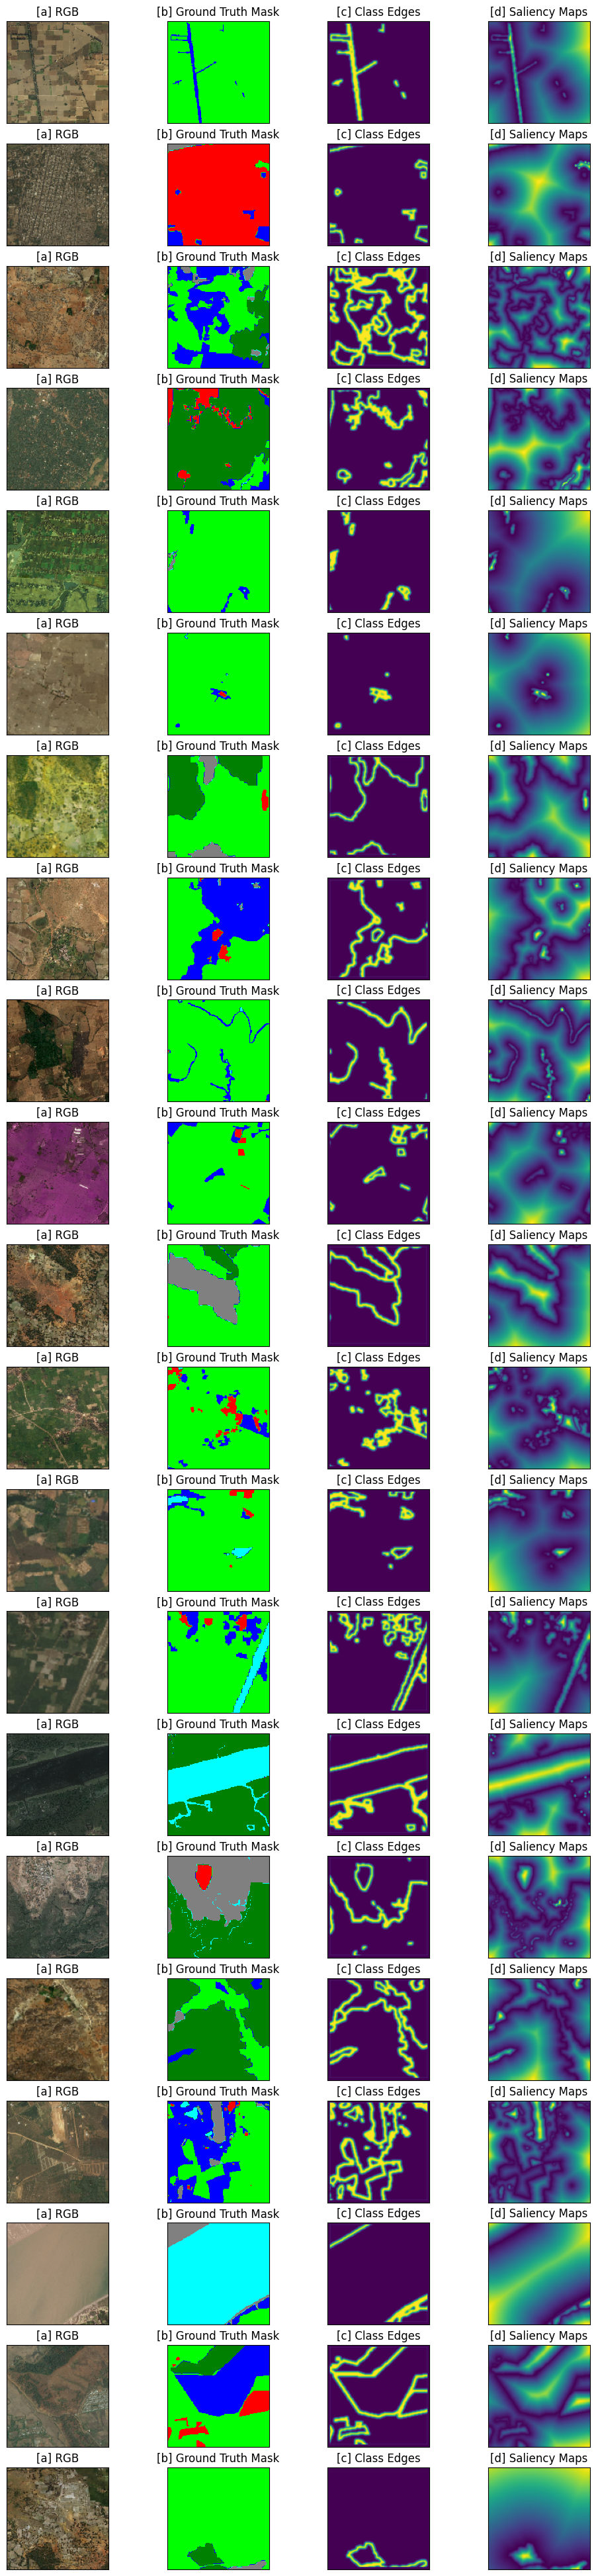

In [6]:
fig, axes = plt.subplots(nrows=21,ncols=4,figsize=(12,50))
#axes      = axes.reshape(-1)

for i,sample in enumerate(TrainDataloader):
    axes[i,0].imshow(sample['inputs'][0][:3].permute(1,2,0)+0.5); axes[i,0].set_title('[a] RGB')
    #axes[i,0].imshow(sample['data_samples'][0].gt_hres_img.data[:-2].permute(1,2,0)); axes[i,0].set_title('[a] 10m/Pix RGB')
    axes[i,1].imshow(sample['data_samples']['gt_sem_seg'][0], cmap = cmap, norm = norm); axes[i,1].set_title('[b] Ground Truth Mask')
    axes[i,2].imshow(sample['data_samples']['gt_hres_edge'][0][0]); axes[i,2].set_title('[c] Class Edges')
    #axes[i,4].imshow(sample['data_samples'][0].gt_hres_mask.data[:3].permute(1,2,0))
    val = sample['data_samples']['gt_hres_mask'][0]; 
    axes[i,3].imshow(val); axes[i,3].set_title('[d] Saliency Maps')
    #axes[i,5].imshow(cv2.resize(val.numpy(),(32,32)))
    
    if i == 20:
        break
for ax in axes.reshape(-1):
    ax.set_xticks([])
    ax.set_yticks([])

In [7]:
sample.keys()

dict_keys(['inputs', 'gt_sem_seg', 'data_samples'])

In [8]:
fig.savefig(f'{dataset}_{rimg_size}.pdf')

In [9]:
class SoftCrossEntropyLoss(torch.nn.Module):
   def __init__(self, loss_weight = 1.0, class_weight = [1.0], T = 1.0):
      super().__init__()
      self.lw = loss_weight
      self.cw = torch.tensor(class_weight)[None,:,None,None]
      self.T  = T

   def forward(self, y_hat, y, **kwargs):
      #y     = F.softmax(y/self.T, dim = 1)
      y_hat = F.softmax(y_hat/self.T, dim = 1)
      y     = self.cw.to(y.device)*y
      loss  = -(y*y_hat.log()).sum(dim = 1)
      return self.lw * loss.mean()
       
   @property
   def loss_name(self):
      return 'soft_ce_loss'


class CrossEntropyLoss(torch.nn.Module):
   def __init__(self, loss_weight = 1.0, class_weight = [1.0], T = 1.0):
      super().__init__()
      self.lw = loss_weight
      self.cw = np.array(class_weight)
      self.T  = T

   def forward(self, y_hat, y, **kwargs):
      #y     = F.softmax(y/self.T, dim = 1)
      y_hat = F.softmax(y_hat/self.T, dim = 1)
      #y     = self.cw[None,:,None,None]*y
      loss  = -(y*y_hat.log()).sum(dim = 1)
      return self.lw * loss.mean()
       
   @property
   def loss_name(self):
      return 'soft_ce_loss'

class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=3.0, reduction='mean'):
        """
        Focal Loss for multi-class classification.
        
        :param alpha: (tensor or float) Balancing factor, shape (C,) where C is the number of classes.
                      If None, no balancing is applied.
        :param gamma: (float) Focusing parameter. Default is 2.0.
        :param reduction: (str) Reduction method: 'mean', 'sum' or 'none'. Default is 'mean'.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets, **kwargs):
        """
        :param inputs: Predicted logits (before softmax), shape (N, C)
        :param targets: Ground truth labels, shape (N,) with values in [0, C-1]
        """
        probs = F.softmax(inputs, dim=1)  # Convert logits to probabilities
        targets_one_hot = F.one_hot(targets.long(), num_classes=inputs.shape[1])  # One-hot encode labels
        pt = (probs * targets_one_hot.permute(0,3,1,2)).sum(dim=1)  # Get the probability of the true class
        
        log_pt = torch.log(pt + 1e-9)  # Avoid log(0)
        focal_weight = (1 - pt) ** self.gamma  # Compute focal weight
        
        if self.alpha is not None:
            alpha_weight = self.alpha[targets] if isinstance(self.alpha, torch.Tensor) else self.alpha
            focal_weight *= alpha_weight
        
        loss = -focal_weight * log_pt  # Compute focal loss
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss  # No reduction
    
    @property
    def loss_name(self):
        return 'focal_loss'

class CrossEntropyLoss(torch.nn.Module):
    def __init__(self, weight=None, reduction='mean'):
        """
        Cross Entropy Loss for multi-class classification.
        
        :param weight: (tensor or None) A manual rescaling weight for each class.
        :param reduction: (str) Reduction method: 'mean', 'sum' or 'none'. Default is 'mean'.
        """
        super(CrossEntropyLoss, self).__init__()
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        :param inputs: Predicted logits (before softmax), shape (N, C)
        :param targets: Ground truth labels, shape (N,) with values in [0, C-1]
        """
        log_probs = F.log_softmax(inputs, dim=1)  # Compute log probabilities
        targets_one_hot = F.one_hot(targets, num_classes=inputs.shape[1]).float()
        
        if self.weight is not None:
            weight = self.weight[targets].unsqueeze(1)
            log_probs = log_probs * weight
        
        loss = -torch.sum(targets_one_hot * log_probs, dim=1)  # Compute loss
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss  # No reduction
    
    @property
    def loss_name(self):
        return 'focal_loss'

class DiceLoss(torch.nn.Module):
    def __init__(self, smooth=1e-6, reduction='mean'):
        """
        Dice Loss for multi-class classification.
        
        :param smooth: (float) Smoothing factor to avoid division by zero.
        :param reduction: (str) Reduction method: 'mean', 'sum' or 'none'. Default is 'mean'.
        """
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        :param inputs: Predicted logits (before softmax), shape (N, C)
        :param targets: Ground truth labels, shape (N,) with values in [0, C-1]
        """
        inputs = F.softmax(inputs, dim=1)  # Convert logits to probabilities
        targets_one_hot = F.one_hot(targets, num_classes=inputs.shape[1]).float()
        
        intersection = torch.sum(inputs * targets_one_hot, dim=0)
        union = torch.sum(inputs, dim=0) + torch.sum(targets_one_hot, dim=0)
        dice_score = (2.0 * intersection + self.smooth) / (union + self.smooth)
        
        loss = 1 - dice_score  # Dice loss
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss  # No reduction
        
class SoftFocalLoss(torch.nn.Module):
   def __init__(self, loss_weight = 1.0, class_weight = [1.0], T = 1.0, alpha =  0.75, gamma = 2):
      super().__init__()
      self.lw = loss_weight
      self.cw = np.array(class_weight)
      self.T  = T
      self.alpha = alpha
      self.gamma = gamma

   def forward(self, y_hat, y, **kwargs):
      y_hat = F.sigmoid(y_hat/self.T)
      ce_loss  = - ((y * y_hat.log()) + ((1 - y) * (1 - y_hat).log()))

      p_t = y_hat * y + (1 - y_hat) * (1 - y)
      loss = ce_loss * ((1 - p_t) ** self.gamma)

      if alpha >= 0:
          alpha_t = self.alpha * y + (1 - self.alpha) * (1 - y)
          loss    = self.alpha_t * loss
      return self.lw * loss.mean()
       
   @property
   def loss_name(self):
      return 'soft_focal_loss'


class SoftBinaryCrossEntropyLoss(torch.nn.Module):
   def __init__(self, loss_weight = 1.0, T = 1.0):
      super().__init__()
      self.lw = loss_weight
      self.T  = T

   def forward(self, y_hat, y, **kwargs):
      #y     = F.sigmoid(y/self.T)
      y_hat = F.sigmoid(y_hat/self.T)
      loss  = - ((y * y_hat.log()) + ((1 - y) * (1 - y_hat).log()))
      return self.lw * loss.mean()

   @property
   def loss_name(self):
      return 'soft_bce_loss'
       
class SoftKLDivLoss():
   def __init__(self, weights = 1.0, T = 1.0):
      super().__init__()
      self.weights = weights

   def forward(self, y_hat, y):
      p = F.softmax(y_hat, 1)
      y = self.weights*y
      loss = (y*(F.log(y/p))).sum() / (w_labels).sum()
      return loss
       
if arch == 'swint':      
    swint =dict(
            type='SwinTransformer',
            pretrain_img_size=224,
            embed_dims= [96, 128][swint_ind],
            patch_size=4,
            window_size=7,
            mlp_ratio=4,
            depths=[[2, 2, 6, 2], [2, 2, 18, 2]][swint_ind],
            num_heads=[[3, 6, 12, 24], [4, 8, 16, 32]][swint_ind], 
            strides=(4, 2, 2, 2),
            out_indices=(0, 1, 2, 3),
            qkv_bias=True,
            qk_scale=None,
            patch_norm=True,
            drop_rate=0.,
            attn_drop_rate=0.,
            drop_path_rate=0.3,
            use_abs_pos_embed=False,
            act_cfg=dict(type='GELU'),
            norm_cfg = dict(type='LN', requires_grad=True))

mixvit = dict(type = 'MixVisionTransformer',
  in_channels = 3,
  embed_dims  = 64,
  num_stages  = 4,
  num_layers  = [3, 4, 6, 3], # 2, 2, 2, 2
  num_heads   = [1, 2, 5, 8],
  patch_sizes = [7, 3, 3, 3],
  sr_ratios   = [8, 4, 2, 1],
  out_indices = (0, 1, 2, 3),
  mlp_ratio   = 4,
  qkv_bias    = True,
  drop_rate   = 0.0,
  attn_drop_rate = 0.0,
  drop_path_rate = 0.1)
  #init_cfg       = dict(type = 'Pretrained',
  #checkpoint = 'https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/segformer/mit_b1_20220624-02e5a6a1.pth'))

resnet = dict(
    type = 'ResNetV1c',
    depth       = resnet_depth,
    num_stages  = 4,
    out_indices = (0, 1, 2, 3),
    dilations   = (1, 1, 2, 4), # 1, 4, 8, 16 #1, 1, 2, 4
    strides     = (1, 2, 2, 2), #1, 2, 2, 2
    norm_cfg    = {'type': 'SyncBN', 'requires_grad': True},
    norm_eval   = False,
    style = 'pytorch',
    contract_dilation = True,
    init_cfg=init_cfg)

mobilenet=dict(
        type='MobileNetV2',
        widen_factor=1.,
        strides=(1, 1, 1, 2, 2, 1, 1), # (1, 2, 2, 1, 1, 1, 1)
        dilations=(1, 1, 1, 2, 2, 4, 4),
        out_indices=(2, 4, 5, 6), # 1, 2, 4, 6
        norm_cfg=dict(type='SyncBN', requires_grad=True))

unet = dict(
        type='UNet',
        in_channels=3,
        base_channels=64,
        num_stages=5,
        strides=(1, 1, 1, 1, 1),
        enc_num_convs=(2, 2, 2, 2, 2),
        dec_num_convs=(2, 2, 2, 2),
        downsamples=(True, True, True, True),
        enc_dilations=(1, 1, 1, 1, 1),
        dec_dilations=(1, 1, 1, 1),
        with_cp=False,
        conv_cfg=None,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        act_cfg=dict(type='ReLU'),
        upsample_cfg=dict(type='InterpConv'),
        norm_eval=False)

if decode_head == 'fcn':
    fcn_head = dict(
            type='FCNHead',
            in_channels=64,
            in_index=4,
            channels=64,
            num_convs=1,
            concat_input=False,
            dropout_ratio=0.1,
            num_classes=num_class,
            norm_cfg=dict(type='SyncBN', requires_grad=True),
            align_corners=False,
            loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0))
_nc = 1 #num_class
if decode_head == 'dlv3':
    if len(use_aux_head): dlv3_in_channels = 4*(max(channels[0]//2,32)) + _nc +1
    else: dlv3_in_channels = channels[3]

    deeplab_head = dict(
         type = 'DepthwiseSeparableASPPHead',
         in_channels = dlv3_in_channels,
         in_index    = 1 if use_aux_head else 3,
         #input_transform = 'resize_concat',
         channels  = min(channels[1],256),
         dilations = dilate_dict[img_size],#(1, 6, 12, 24), #(1, 6, 12, 24), # 1, 12, 24, 36 # (1, 6, 12, 24)
         c1_in_channels = channels[0],
         c1_channels    = channels[0]//4, #48
         dropout_ratio  = 0.1,
         num_classes    = num_class,
         activation     = None,
         norm_cfg       = None if batch_size ==1 else {'type': 'SyncBN', 'requires_grad': True},
         align_corners  = True,
         loss_decode    = dict(type = 'CrossEntropyLoss', use_sigmoid = False, loss_weight = 1.0, class_weight = class_weight))
         #loss_decode   = dict(type = 'DiceLoss', use_sigmoid= False, loss_weight= 1.0))
         #loss_decode    = dict(type = 'LovaszLoss', loss_type = 'multi_class', per_image = True))
         #loss_decode    = FocalLoss()) #class_weight = class_weight

if decode_head == 'upn':
    if len(use_aux_head): upn_in_channels  = [256 +1, 256 + _nc, 256, 256]
    else: upn_in_channels  = channels
        
    upper_head = dict(type = 'UPerHead',
      in_channels= upn_in_channels,
      in_index= [0, 1, 2, 3],
      pool_scales= (1, 2, 3, 6),
      channels= 512,
      dropout_ratio= 0.1,
      num_classes= num_class,
      norm_cfg= {'type': 'SyncBN', 'requires_grad': True},
      align_corners = False,
      loss_decode   = dict(type = 'CrossEntropyLoss', use_sigmoid= False, loss_weight= 1.0, class_weight = class_weight))

if decode_head == 'sfm':
    if len(use_aux_head): sfm_in_channels  = [256 +1, 256 + num_class, 256, 256]
    else: sfm_in_channels  = channels

    #16,24,32,64,96,160,320
    segfm_head = dict(
            type          = 'SegformerHead',
            in_channels   = sfm_in_channels, #[32, 64, 160, 256] [96, 192, 384, 768], #
            in_index      = [0, 1, 2, 3],
            dilations     = [1, 1, 1, 1],
            channels      = 256,
            dropout_ratio = 0.1,
            num_classes   = num_class,
            activation    = None,
            norm_cfg=dict(type = 'SyncBN', requires_grad=True),
            align_corners      = False,
            loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, class_weight = class_weight))

if len(use_aux_head):
    auxiliary_head_1 = dict(
       type = 'FCNHead',
       loss_key    = 'gt_hres_img',
       in_channels = channels[0],
       in_index    = 0,
       channels    = channels[0]//2,
       num_convs   = 1,
       concat_input  = False,
       dropout_ratio = 0.1,
       num_classes   = 5,
       activation    = None,
       norm_cfg = {'type': 'SyncBN', 'requires_grad': True},
       align_corners = True,
       loss_decode   = dict(type = 'MSELoss', loss_weight = cfg.aux1_lw))
    
    auxiliary_head_2 = dict(
       type = 'FCNHead',
       loss_key    = 'gt_hres_edge',
       in_channels = channels[0],
       in_index    = 0,
       channels    = channels[0]//2,
       #input_transform = 'resize_concat',
       num_convs     = 1,
       concat_input  = False,
       dropout_ratio = 0.1,
       num_classes   = 1,
       activation    = None,
       norm_cfg = {'type': 'SyncBN', 'requires_grad': True},
       align_corners = True,
       loss_decode   = SoftBinaryCrossEntropyLoss(loss_weight = cfg.aux2_lw, T = cfg.T))
    
    auxiliary_head_3 = dict(
       type = 'FCNHead',
       loss_key    = 'gt_hres_mask',
       in_channels =  channels[1],
       in_index    =  1,
       #input_transform = 'resize_concat',
       channels    = channels[1]//2,
       num_convs   = 1,
       concat_input  = False,
       dropout_ratio = 0.1,
       num_classes   = _nc,
       activation    = None,
       norm_cfg      = {'type': 'SyncBN', 'requires_grad': True},
       align_corners = True,
       loss_decode   = SoftBinaryCrossEntropyLoss(loss_weight = cfg.aux3_lw, T = cfg.T)) #class_weight = class_weight

    cfg.model.auxiliary_head_1 = auxiliary_head_1
    cfg.model.auxiliary_head_2 = auxiliary_head_2
    cfg.model.auxiliary_head_3 = auxiliary_head_3
    

In [10]:
del cfg.model.auxiliary_head
del cfg.model.pretrained
cfg.model.use_aux_head = use_aux_head
if arch == 'swint':
   cfg.model.backbone = swint#resnet50
if arch == 'mixvit':
   cfg.model.backbone = mixvit
if arch in ['resnet18','resnet34','resnet50']:
   cfg.model.backbone = resnet
if arch == 'mnetv2':
    cfg.model.backbone = mobilenet
if arch == 'unet':
    cfg.model.backbone = unet
    
cfg.model.num_class = num_class

if decode_head == 'dlv3':
   cfg.model.decode_head   = deeplab_head
if decode_head == 'upn':
    cfg.model.decode_head  = upper_head
if decode_head == 'sfm':
    cfg.model.decode_head  = segfm_head
if decode_head == 'fcn':
    cfg.model.decode_head  = fcn_head

In [11]:
#itr_per_epoch = 281

In [12]:
from mmseg.registry import MODELS, EVALUATOR
from mmseg.utils import register_all_modules
from mmseg.evaluation import IoUMetric

register_all_modules()

model = MODELS.build(cfg.model)

if arch == 'mnetv2':
    model.backbone.conv1.conv = torch.nn.Conv2d(inp_channel, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
if arch in ['resnet18','resnet34','resnet50']:
    model.backbone.stem[0] = torch.nn.Conv2d(inp_channel, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
if arch == 'swint':
    model.backbone.patch_embed.projection = torch.nn.Conv2d(inp_channel, channels[0], kernel_size=(4, 4), stride=(4, 4))
if arch == 'mixvit':
    model.backbone.layers[0][0].projection = torch.nn.Conv2d(inp_channel, 64, kernel_size=(7, 7), stride=(7, 7))
if arch == 'unet':
    model.backbone.encoder[0][0].convs[0].conv = torch.nn.Conv2d(inp_channel, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    
val_evaluator = IoUMetric(ignore_index = None, iou_metrics = ['mIoU','mFscore'], output_dir= exp_path, num_class =num_class, class_names = class_names, save_fig_int = 0)

/projects/Deep-Learning-For-Remote-Sensing/libs/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:281: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


04/28 10:40:11 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.


In [13]:
if arch == 'resnet50':
    mdl = torch.load('weights/deeplabv3plus_r50-d8_769x769_80k_cityscapes_20200606_210233-0e9dfdc4.pth')['state_dict']
    ignore_keys = ['backbone.stem.0.','decode_head.conv_seg.weight', 'auxiliary_head.conv_seg.weight','decode_head.conv_seg.bias','auxiliary_head.conv_seg.bias']
    new_mdl = {}
    for key in mdl.keys():
        if inp_channel > 3 and 'backbone.stem.0' in key:
            continue
        if 'auxiliary_head' in key or 'decode_head' in key:
            continue
        #if key not in ignore_keys:
        new_mdl[key] = mdl[key]
    model.load_state_dict(new_mdl,strict = False)

if arch in ['resnet18', 'resnet34']:
    mdl = torch.load('weights/deeplabv3plus_r18-d8_769x769_80k_cityscapes_20201226_083346-f326e06a.pth')['state_dict']
    ignore_keys = ['backbone.stem.0.','decode_head.conv_seg.weight', 'auxiliary_head.conv_seg.weight','decode_head.conv_seg.bias','auxiliary_head.conv_seg.bias']
    new_mdl = {}
    for key in mdl.keys():
        if inp_channel > 3 and 'backbone.stem.0' in key:
            continue
        if 'auxiliary_head' in key or 'decode_head' in key:
            continue
        #if key not in ignore_keys:
        new_mdl[key] = mdl[key]
    model.load_state_dict(new_mdl,strict = False)
    
if arch == 'unet':
    mdl = torch.load('weights/fcn_unet_s5-d16_4x4_512x1024_160k_cityscapes_20211210_145204-6860854e.pth')['state_dict']
    #backbone.encoder.0.0.
    ignore_keys = ['decode_head.conv_seg.weight', 'decode_head.conv_seg.bias']
    new_mdl = {}
    for key in mdl.keys():
        if 'auxiliary_head' in key:
            continue
        if key in ignore_keys:
            continue
        new_mdl[key] = mdl[key]
    model.load_state_dict(new_mdl,strict = False)

if arch == 'swint':
    paths =  ['weights/upernet_swin_tiny_patch4_window7_512x512_160k_ade20k_pretrain_224x224_1K_20210531_112542-e380ad3e.pth']
    paths += ['weights/upernet_swin_base_patch4_window7_512x512_160k_ade20k_pretrain_224x224_1K_20210526_192340-593b0e13.pth']
    mdl = torch.load(paths[swint_ind])
    ignore_keys = ['backbone.stem.0.','decode_head.conv_seg.weight', 'auxiliary_head.conv_seg.weight','decode_head.conv_seg.bias','auxiliary_head.conv_seg.bias']
    new_mdl = {}
    ignore_keys = ['decode_head.conv_seg.weight', 'decode_head.conv_seg.bias']
    new_mdl = {}
    for key in mdl.keys():
        if 'auxiliary_head' in key:
            continue
        if key in ignore_keys:
            continue
        new_mdl[key] = mdl[key]
    model.load_state_dict(new_mdl,strict = False)

if arch == 'mixvit':
    mdl = torch.load('weights/segformer_mit-b2_512x512_160k_ade20k_20210726_112103-cbd414ac.pth')['state_dict']
    ignore_keys = ['backbone.stem.0.','decode_head.conv_seg.weight', 'auxiliary_head.conv_seg.weight','decode_head.conv_seg.bias','auxiliary_head.conv_seg.bias']
    new_mdl = {}
    ignore_keys = ['decode_head.conv_seg.weight', 'decode_head.conv_seg.bias']
    new_mdl = {}
    for key in mdl.keys():
        if 'auxiliary_head' in key:
            continue
        if key in ignore_keys:
            continue
        new_mdl[key] = mdl[key]
    model.load_state_dict(new_mdl,strict = False)


In [14]:
if len(use_aux_head):
    #cfg.model.decode_head.loss_decode      = cfg.model.decode_head.loss_decode.loss_name
    cfg.model.auxiliary_head_2.loss_decode = cfg.model.auxiliary_head_2.loss_decode.loss_name
    cfg.model.auxiliary_head_3.loss_decode = cfg.model.auxiliary_head_3.loss_decode.loss_name
'''
with open(f'{exp_path}/config.json', 'w') as file:
    json.dump(cfg.to_dict(), file)
'''
model.to('cuda')
if len(use_aux_head):
    for head in model.auxiliary_heads:
        head.to('cuda')

In [15]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")
#41,230,051
#29,341,155

Total parameters: 29,341,607


Training starts ...


04/28 10:42:54 - mmengine - INFO - per class results:
04/28 10:42:54 - mmengine - INFO - 
+---------+-------------------+--------------------+-------------------+-------------------+--------------------+
|  Class  |        IoU        |        Acc         |       Fscore      |     Precision     |       Recall       |
+---------+-------------------+--------------------+-------------------+-------------------+--------------------+
|    0    |        0.15       |        0.56        |        0.3        |        0.2        |        0.56        |
|    1    |       10.79       |        18.1        |       19.48       |        21.1       |        18.1        |
|    2    |       62.18       |       71.76        |       76.68       |       82.33       |       71.76        |
|    3    |        1.57       |        1.68        |        3.09       |       20.02       |        1.68        |
|    4    |       32.88       |       75.35        |       49.49       |       36.85       |       75.35        

Epoch: 1/10 | Training Loss: 138.9426 | Validation Loss: 20.9000
Validation IoU improved (0.000000 --> 20.900000).  Saving model ...


04/28 10:46:03 - mmengine - INFO - per class results:
04/28 10:46:03 - mmengine - INFO - 
+---------+--------------------+-------------------+--------------------+--------------------+-------------------+
|  Class  |        IoU         |        Acc        |       Fscore       |     Precision      |       Recall      |
+---------+--------------------+-------------------+--------------------+--------------------+-------------------+
|    0    |        0.0         |        0.0        |        nan         |        0.0         |        0.0        |
|    1    |       25.65        |       38.45       |       40.82        |       43.51        |       38.45       |
|    2    |       70.16        |        82.2       |       82.46        |       82.73        |        82.2       |
|    3    |        1.94        |        2.05       |        3.81        |       26.56        |        2.05       |
|    4    |       42.55        |       80.72       |        59.7        |       47.36        |       80.7

Epoch: 2/10 | Training Loss: 114.2036 | Validation Loss: 25.7700
Validation IoU improved (20.900000 --> 25.770000).  Saving model ...


04/28 10:49:29 - mmengine - INFO - per class results:
04/28 10:49:29 - mmengine - INFO - 
+---------+--------------------+--------------------+-------------------+--------------------+--------------------+
|  Class  |        IoU         |        Acc         |       Fscore      |     Precision      |       Recall       |
+---------+--------------------+--------------------+-------------------+--------------------+--------------------+
|    0    |        0.0         |        0.0         |        nan        |        nan         |        0.0         |
|    1    |       42.16        |       65.59        |       59.31       |       54.13        |       65.59        |
|    2    |       70.47        |       82.77        |       82.68       |       82.59        |       82.77        |
|    3    |        3.79        |        4.23        |        7.29       |       26.52        |        4.23        |
|    4    |       49.81        |       79.11        |        66.5       |       57.36        |    

Epoch: 3/10 | Training Loss: 100.2102 | Validation Loss: 31.5700
Validation IoU improved (25.770000 --> 31.570000).  Saving model ...


04/28 10:53:17 - mmengine - INFO - per class results:
04/28 10:53:17 - mmengine - INFO - 
+---------+--------------------+-------------------+-------------------+--------------------+-------------------+
|  Class  |        IoU         |        Acc        |       Fscore      |     Precision      |       Recall      |
+---------+--------------------+-------------------+-------------------+--------------------+-------------------+
|    0    |        0.0         |        0.0        |        nan        |        nan         |        0.0        |
|    1    |       44.44        |       61.55       |       61.53       |       61.51        |       61.55       |
|    2    |       75.72        |       88.54       |       86.18       |       83.95        |       88.54       |
|    3    |        4.38        |        5.02       |        8.39       |       25.37        |        5.02       |
|    4    |       54.18        |       78.29       |       70.28       |       63.76        |       78.29       

Epoch: 4/10 | Training Loss: 90.8335 | Validation Loss: 36.9100
Validation IoU improved (31.570000 --> 36.910000).  Saving model ...


04/28 10:57:26 - mmengine - INFO - per class results:
04/28 10:57:26 - mmengine - INFO - 
+---------+--------------------+-------------------+-------------------+-------------------+-------------------+
|  Class  |        IoU         |        Acc        |       Fscore      |     Precision     |       Recall      |
+---------+--------------------+-------------------+-------------------+-------------------+-------------------+
|    0    |        0.0         |        0.0        |        nan        |        nan        |        0.0        |
|    1    |        47.3        |       77.35       |       64.22       |       54.91       |       77.35       |
|    2    |       68.73        |       78.36       |       81.47       |       84.83       |       78.36       |
|    3    |        3.68        |        4.28       |        7.1        |       20.95       |        4.28       |
|    4    |       49.14        |       83.87       |        65.9       |       54.27       |       83.87       |
|    5

Epoch: 5/10 | Training Loss: 85.3522 | Validation Loss: 32.8200
EarlyStopping counter: 1 out of 10


04/28 11:01:37 - mmengine - INFO - per class results:
04/28 11:01:37 - mmengine - INFO - 
+---------+-------------------+--------------------+-------------------+-------------------+--------------------+
|  Class  |        IoU        |        Acc         |       Fscore      |     Precision     |       Recall       |
+---------+-------------------+--------------------+-------------------+-------------------+--------------------+
|    0    |        0.0        |        0.0         |        nan        |        nan        |        0.0         |
|    1    |       53.76       |       75.08        |       69.93       |       65.44       |       75.08        |
|    2    |       73.98       |       83.89        |       85.04       |       86.23       |       83.89        |
|    3    |        6.01       |        7.2         |       11.34       |       26.69       |        7.2         |
|    4    |       54.61       |       81.59        |       70.65       |       62.29       |       81.59        

Epoch: 6/10 | Training Loss: 80.9018 | Validation Loss: 36.9600
Validation IoU improved (36.910000 --> 36.960000).  Saving model ...


04/28 11:05:57 - mmengine - INFO - per class results:
04/28 11:05:57 - mmengine - INFO - 
+---------+--------------------+-------------------+--------------------+-------------------+-------------------+
|  Class  |        IoU         |        Acc        |       Fscore       |     Precision     |       Recall      |
+---------+--------------------+-------------------+--------------------+-------------------+-------------------+
|    0    |        0.0         |        0.0        |        nan         |        nan        |        0.0        |
|    1    |        52.8        |       75.77       |       69.11        |       63.52       |       75.77       |
|    2    |       73.62        |       81.99       |        84.8        |       87.81       |       81.99       |
|    3    |        7.94        |        9.86       |       14.72        |       28.96       |        9.86       |
|    4    |       51.18        |       79.49       |       67.71        |       58.97       |       79.49       

Epoch: 7/10 | Training Loss: 76.5346 | Validation Loss: 37.4300
Validation IoU improved (36.960000 --> 37.430000).  Saving model ...


04/28 11:10:46 - mmengine - INFO - per class results:
04/28 11:10:46 - mmengine - INFO - 
+---------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  Class  |        IoU         |        Acc         |       Fscore       |     Precision      |       Recall       |
+---------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0    |        0.0         |        0.0         |        nan         |        nan         |        0.0         |
|    1    |       54.93        |       74.28        |       70.91        |       67.84        |       74.28        |
|    2    |       78.82        |       90.96        |       88.15        |       85.52        |       90.96        |
|    3    |        9.28        |        11.6        |       16.98        |       31.64        |        11.6        |
|    4    |       52.07        |       79.54        |       68.48        |       60.12     

Epoch: 8/10 | Training Loss: 72.4973 | Validation Loss: 40.5700
Validation IoU improved (37.430000 --> 40.570000).  Saving model ...


04/28 11:16:21 - mmengine - INFO - per class results:
04/28 11:16:21 - mmengine - INFO - 
+---------+-------------------+-------------------+-------------------+--------------------+-------------------+
|  Class  |        IoU        |        Acc        |       Fscore      |     Precision      |       Recall      |
+---------+-------------------+-------------------+-------------------+--------------------+-------------------+
|    0    |        0.0        |        0.0        |        nan        |        nan         |        0.0        |
|    1    |       52.81       |       63.24       |       69.12       |       76.21        |       63.24       |
|    2    |       71.62       |       81.75       |       83.46       |       85.25        |       81.75       |
|    3    |       12.11       |       17.66       |       21.61       |       27.83        |       17.66       |
|    4    |       57.41       |       76.23       |       72.94       |       69.92        |       76.23       |
|    5

Epoch: 9/10 | Training Loss: 68.8211 | Validation Loss: 38.6200
EarlyStopping counter: 1 out of 10


04/28 11:22:51 - mmengine - INFO - per class results:
04/28 11:22:51 - mmengine - INFO - 
+---------+-------------------+-------------------+-------------------+-------------------+-------------------+
|  Class  |        IoU        |        Acc        |       Fscore      |     Precision     |       Recall      |
+---------+-------------------+-------------------+-------------------+-------------------+-------------------+
|    0    |        0.0        |        0.0        |        nan        |        nan        |        0.0        |
|    1    |       56.09       |       71.55       |       71.87       |       72.19       |       71.55       |
|    2    |       79.79       |       90.92       |       88.76       |        86.7       |       90.92       |
|    3    |       14.25       |       20.31       |       24.95       |       32.34       |       20.31       |
|    4    |       58.15       |       78.47       |       73.54       |       69.19       |       78.47       |
|    5    |   

Epoch: 10/10 | Training Loss: 65.5932 | Validation Loss: 42.2700
Validation IoU improved (40.570000 --> 42.270000).  Saving model ...


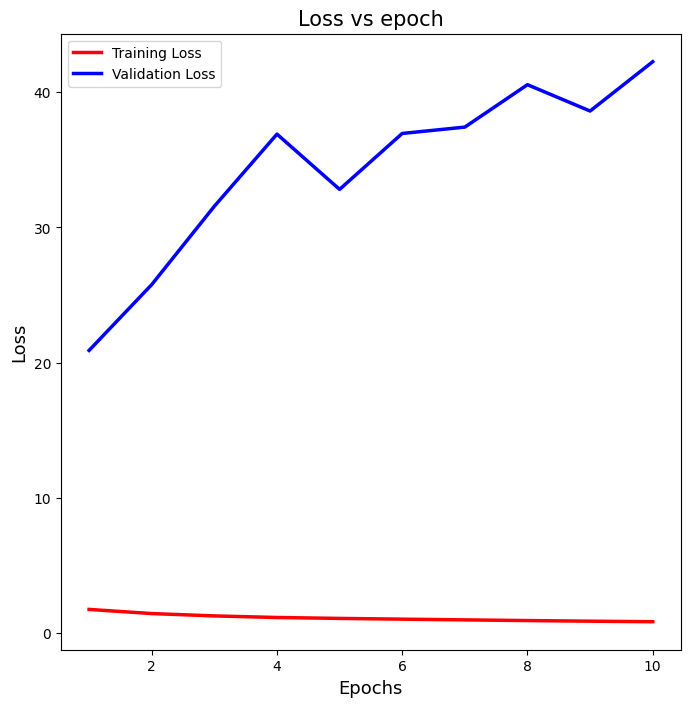


Training Completed in 42m 41.35s.


In [16]:
from train import *
if optim == 'sgd':
    optimizer = SGD(model.parameters(), lr = lr, momentum = 0.9, weight_decay = 0.0005)
    scheduler = None#PolyLR(optimizer, eta_min = 0.0001, power = 0.9, begin = 0, end = 40000, by_epoch = False)
    #scheduler = PolynomialLR(optimizer, total_iters = 40000, power=0.9, last_epoch=-1)
if optim == 'adam':
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = None
    
train(model, 
      TrainDataloader, 
      ValDataloader, 
      epochs, 
      optimizer, 
      scheduler,
      evaluator = val_evaluator,
      clip_grad = clip_grad,
      regularization = regularization,#"L2", 
      reg_lambda = 1e-6, 
      patience = pat, 
      verbose = True, 
      device = 'cuda', 
      output_dir = exp_path)
torch.save(model.state_dict(), f'{exp_path}/final_checkpoint.pth')

In [17]:
import glob

val_evaluator = IoUMetric(ignore_index = None, iou_metrics = ['mIoU','mFscore'], output_dir= 'test', num_class =num_class, class_names = class_names)
if dataset == 'lcai':
   val_dataset   = LandCoverDataset(split = 'test', img_size = img_size, filter_data = False, mean = mean)
   ValDataloader = DataLoader(val_dataset, batch_size  = 3*batch_size)
model.train()

#exp_path = 'logs/005/lcai_v3_resnet50_dlv3_5cls_0.005_0.0_0.0_0.0_s1'
path = f'{exp_path}/checkpoint.pt'
mdl = torch.load(path)#['state_dict']
model.load_state_dict(mdl)
model.to('cuda')
if len(use_aux_head):
    for head in model.auxiliary_heads:
        head.to('cuda')
model.eval()

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): SyncBatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): SyncBatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): SyncBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SyncBatchNorm(64, 

In [18]:
val_evaluator.results = []
num_classes = 5
ValDataloader   = DataLoader(val_dataset, batch_size   = 3*batch_size, num_workers =0)
for idx, data_batch in tqdm(enumerate(ValDataloader)):
    with torch.no_grad():
        #outputs   = model.val_step(data_batch)
        #data_batch             = model.data_preprocessor(data_batch, True)
        preds = model.predict(data_batch['inputs'].float().to('cuda'),data_batch['data_samples'])
        '''
        for i in range(preds['pred_sem_seg'].shape[0]):
            pred_mask = preds['pred_sem_seg'][i][0].detach().cpu().numpy()
            #mask = remove_small_objects(pred_mask, min_size=225)
            mask = morphological_clean(mask)
            preds['pred_sem_seg'][i][0] = torch.tensor(mask).cuda()
        '''
        val_evaluator.process(data_samples=preds, data_batch = None)
        

14it [00:51,  3.67s/it]


In [19]:
import pandas as pd
res = val_evaluator.compute_metrics(val_evaluator.results)
pd.DataFrame(res, index = ['']).to_csv(f'{exp_path}/best_result.csv')

04/28 11:23:50 - mmengine - INFO - per class results:
04/28 11:23:50 - mmengine - INFO - 
+---------+-------------------+-------------------+-------------------+-------------------+-------------------+
|  Class  |        IoU        |        Acc        |       Fscore      |     Precision     |       Recall      |
+---------+-------------------+-------------------+-------------------+-------------------+-------------------+
|    0    |        0.0        |        0.0        |        nan        |        nan        |        0.0        |
|    1    |       56.09       |       71.55       |       71.87       |       72.19       |       71.55       |
|    2    |       79.79       |       90.92       |       88.76       |        86.7       |       90.92       |
|    3    |       14.25       |       20.31       |       24.95       |       32.34       |       20.31       |
|    4    |       58.15       |       78.47       |       73.54       |       69.19       |       78.47       |
|    5    |   

In [20]:
(40.48 + 68.12 + 54.97 + 49.48)/4

53.262499999999996

In [21]:
ubn, agr, rng, fst, wtr, brn, unw
unw, ubn, agr, rng, fst, wtr, brn,

NameError: name 'ubn' is not defined

In [ ]:
#test_scores(model, ValDataloader, device = 'cuda')

In [ ]:
with open(f'{exp_path}/best_result_all.txt','w') as file:
    file.write(val_evaluator.log.get_csv_string())

In [ ]:
pd.DataFrame(res, index = [''])